## Referece
- [CSDN_Focal_Loss](https://blog.csdn.net/u014380165/article/details/77019084)
- [Medium Focal_Loss](https://medium.com/@chih.sheng.huang821/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E6%90%8D%E5%A4%B1%E5%87%BD%E6%95%B8-loss-function-huber-loss%E5%92%8C-focal-loss-bb757494f85e)
- [Customised Loss function in Keras](https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras)

In [1]:
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

Using TensorFlow backend.


## Load from keras.datasets.cifar10

In [2]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

170500096/170498071 [==============================] - 6s 0us/step


## Preprocessing

In [3]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
test: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [4]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [5]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)#, momentum=MOMENTUM)

## Training (Add Callback)

## Customised Loss function:
- $Focal$ $loss$ = $(sample$ $weight)$$*(easy$ $hard$ $weight)*(cross$ $entropy) =$ $\alpha * (1-pt)^{\gamma} * (-log(pt))$ 

In [6]:
a = tf.convert_to_tensor([2, 3], tf.float32)
b = tf.convert_to_tensor(2, tf.float32)
c = tf.pow(a, b)

with tf.Session() as sess:
    aa, bb, cc = sess.run([a, b, c])
print(aa, bb, cc)

[2. 3.] 2.0 [4. 9.]


In [7]:
def focal_loss(alpha=4, gamma=2.0):
    gamma = float(gamma)
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred_e = tf.add(y_pred, epsilon)
        sample_weight = float(alpha)
        easy_hard_weight = tf.pow(tf.subtract(1.0, y_pred_e), gamma)
        cross_entropy = tf.multiply(y_true, - tf.log(y_pred_e))
        focal_loss = tf.multiply(sample_weight, tf.multiply(easy_hard_weight, cross_entropy))
        focal_loss_max = tf.reduce_max(focal_loss, axis=1)
        focal_loss_mean = tf.reduce_mean(focal_loss_max)
        return focal_loss_mean
    return focal_loss_fixed

## Training

In [8]:
callback=1
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                loss_func = 'categorical_crossentropy',
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1], CALLBACKS= callback):
    model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              epochs=e, batch_size=bs, shuffle=True, callbacks=CALLBACKS) #add callback "early stop"
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

In [9]:
def confusion_matirx_stat(con_matrix, log_enable=True):
    '''Given a confusion matrix and return typical index'''
    result = {}
    con_stat = {}
    for i in range(0, con_matrix.shape[0]):
        TP = con_matrix[i, i]
        FN = np.sum(con_matrix[i, :]) - TP
        FP = np.sum(con_matrix[:, i]) - TP
        TN = np.sum(con_matrix) - TP - FP - FN
        TPR, FNR = TP / (TP + FN), FN / (TP + FN)
        TNR, FPR = TN / (TN + FP), FP / (TN + FP)
        Precesion, Recall = TP / (TP + FP), TP / (TP + FN)
        F1 = 2 * (Precesion * Recall) / (Precesion + Recall)
        ACC = (TP+TN) / (TP+TN+FP+FN)
        con_stat['TP'], con_stat['TN'], con_stat['FP'], con_stat['FN'] = TP, TN, FP, FN
        con_stat['TPR'], con_stat['FNR'] = TPR, FNR
        con_stat['TNR'], con_stat['FPR'] = TNR, FPR
        con_stat['Precesion'], con_stat['Recall'] = Precesion, Recall
        con_stat['F1'], con_stat['ACC'] = F1, ACC
        result['cls_'+str(i)] = con_stat.copy()
        if log_enable:
            print('class_'+str(i+1))
            print('TP: {:04} FP: {:04} \nFN: {:04} TN: {:04}'.format(TP, FP, FN, TN))
            print('total:', TP+TN+FP+FN)
            print('TPR: {:.3} TNR: {:.3f} \nFNR: {:.3f} FPR: {:.3f}'.format(TPR, TNR, FNR, FPR))
            print('ACC: {:.3f}'.format(ACC))
            print('Precesion: {:.3f}\nRecall: {:.3f}'.format(Precesion, Recall))
            print('F1_score: {:.3f}'.format(F1))
            print()
    return result

In [10]:
class confusion_index(Callback):
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        #record_items = ["val_f1sc", "val_acc", 
        #                "val_tpr", "val_fpr", "val_tnr", "val_fnr",
        #                "val_fp", "val_fn", "val_tp", "val_tn"]
        record_items = ['cls_'+str(i) for i in range(0, 10)]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    def on_epoch_end(self, epoch, logs={}, thred=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = y_pred.argmax(axis=1)
        c_matrix = confusion_matrix(y_true, y_pred)
        result = confusion_matirx_stat(c_matrix, log_enable=False)
        for r in result.keys():
            logs[r] = result[r].copy()
    '''
    def on_train_end():
        pass
    def on_epoch_begin():
        pass
    def on_batch_begin():
        pass
    def on_batch_end():
        pass
    '''

## ReduceLROnPlateau

In [11]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
#customised callback "confusion_index"
con_stats = confusion_index()
CALLBACKS = [early_stop, checkpoint, lr_reducer, con_stats]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 172us/step - loss: 1.9871 - acc: 0.3171 - val_loss: 1.6630 - val_acc: 0.4129

Epoch 00001: val_loss improved from inf to 1.66304, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 7s 148us/step - loss: 1.7365 - acc: 0.3845 - val_loss: 1.6046 - val_acc: 0.4349

Epoch 00002: val_loss improved from 1.66304 to 1.60458, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 147us/step - loss: 1.6776 - acc: 0.4029 - val_loss: 1.5699 - val_acc: 0.4480

Epoch 00003: val_loss improved from 1.60458 to 1.56995, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 146us/step - loss: 1.6405 - acc: 0.4184 - val_loss: 1.5618 - val_acc: 0.4518

Epoch 00004: val_loss improved from 1.56995 to 1.56180, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [=====================

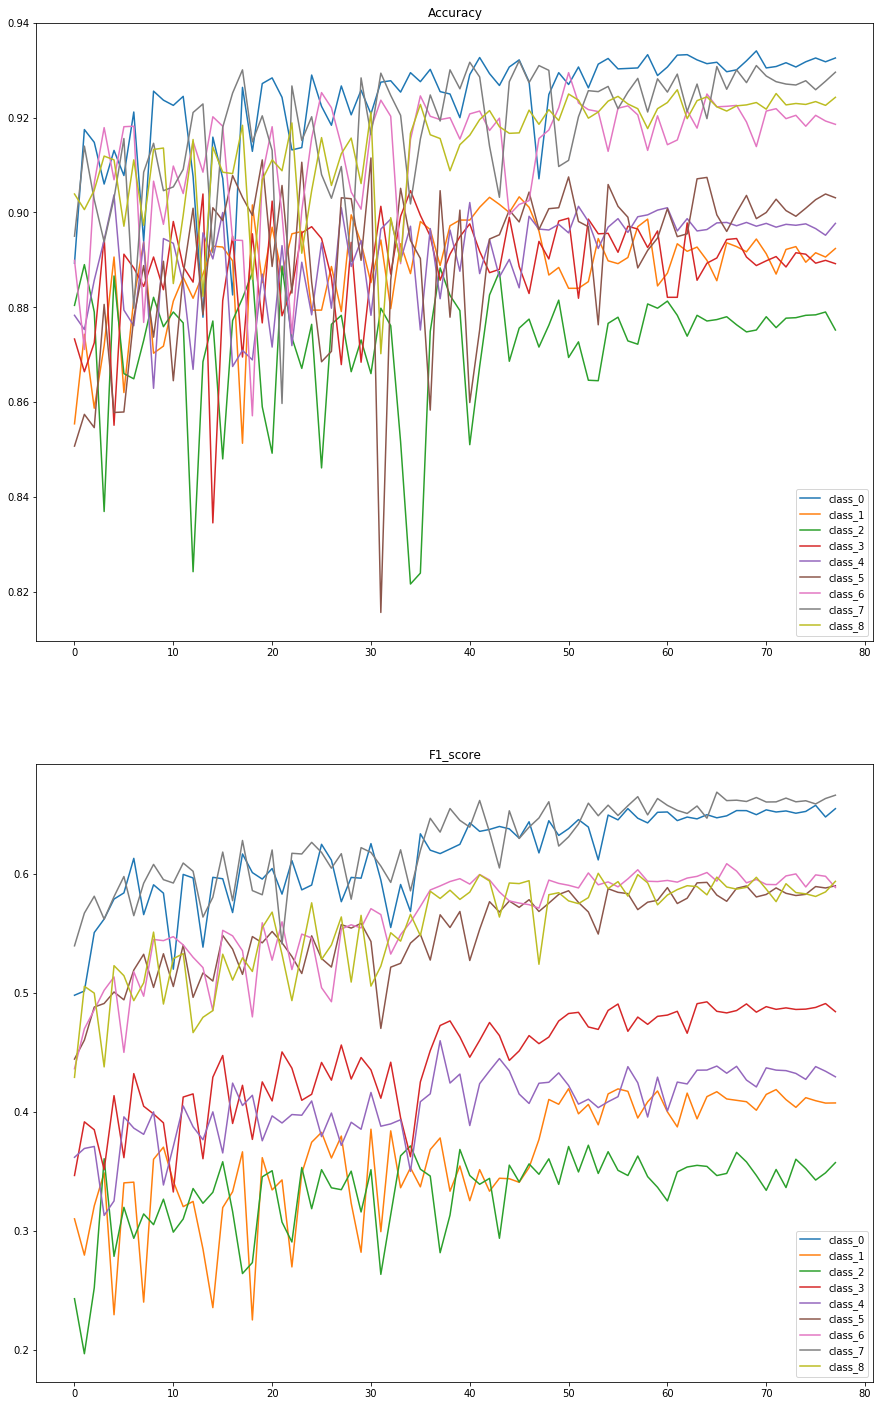

In [12]:
fig = plt.figure(figsize=[15, 25])
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for c in range(0, 9):
    tmp_cls = model.history.history['cls_'+str(c+1)]
    x = range(len(tmp_cls))
    y1, y2 = [], []
    for cc in range(len(tmp_cls)):
        y1.append(tmp_cls[cc]['ACC'])
        y2.append(tmp_cls[cc]['F1'])
    ax1.plot(x, y1, label='class_'+str(c))
    ax2.plot(x, y2, label='class_'+str(c))
ax1.set_title('Accuracy')
ax2.set_title('F1_score')
ax1.legend()
ax2.legend()
plt.show()

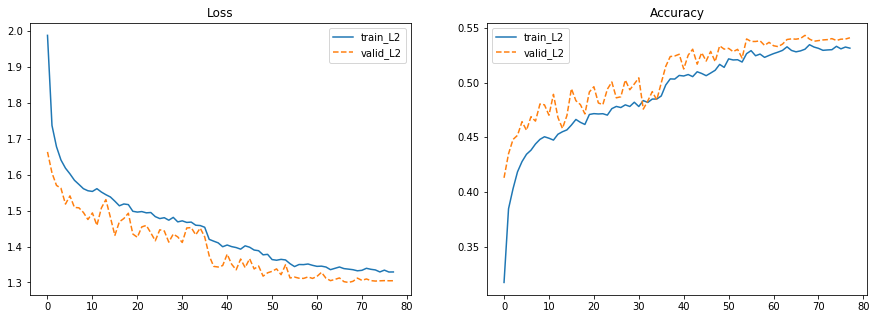

In [13]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
plot_result(record, 'L2', ax1, ax2)
plt.show()

## Focal_loss_training

In [14]:
def focal_loss(alpha=4, gamma=2.0):
    gamma = float(gamma)
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred_e = tf.add(y_pred, epsilon)
        sample_weight = float(alpha)
        easy_hard_weight = tf.pow(tf.subtract(1.0, y_pred_e), gamma)
        cross_entropy = tf.multiply(y_true, - tf.log(y_pred_e))
        focal_loss = tf.multiply(sample_weight, tf.multiply(easy_hard_weight, cross_entropy))
        focal_loss_max = tf.reduce_max(focal_loss, axis=1)
        focal_loss_mean = tf.reduce_mean(focal_loss_max)
        return focal_loss_mean
    return focal_loss_fixed

In [15]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
#customised callback "confusion_index"
con_stats = confusion_index()
CALLBACKS = [early_stop, checkpoint, lr_reducer, con_stats]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS, loss_func=focal_loss(1.0,2.0))
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 163us/step - loss: 1.5248 - acc: 0.3065 - val_loss: 1.1900 - val_acc: 0.4015

Epoch 00001: val_loss improved from inf to 1.18997, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 7s 141us/step - loss: 1.2404 - acc: 0.3806 - val_loss: 1.1419 - val_acc: 0.4112

Epoch 00002: val_loss improved from 1.18997 to 1.14189, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 140us/step - loss: 1.1808 - acc: 0.3982 - val_loss: 1.0860 - val_acc: 0.4405

Epoch 00003: val_loss improved from 1.14189 to 1.08598, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 140us/step - loss: 1.1508 - acc: 0.4138 - val_loss: 1.0569 - val_acc: 0.4504

Epoch 00004: val_loss improved from 1.08598 to 1.05692, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [=====================

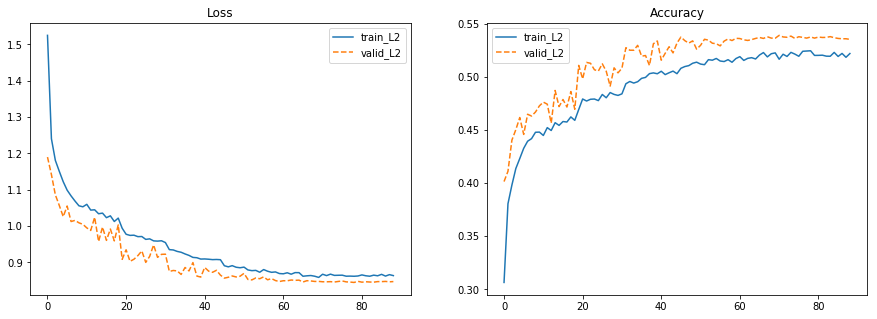

In [16]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
plot_result(record, 'L2', ax1, ax2)
plt.show()

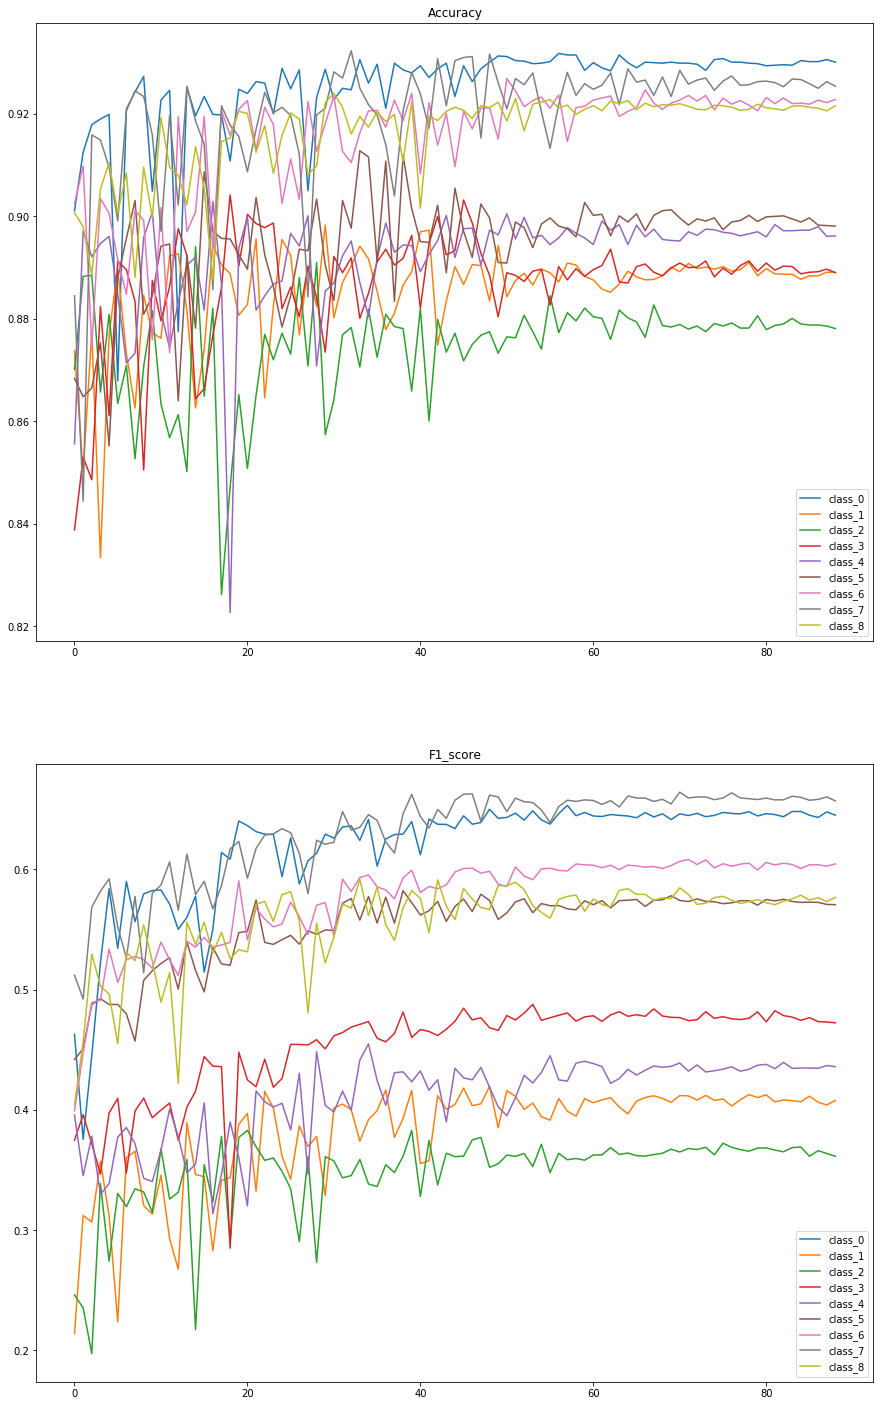

In [17]:
fig = plt.figure(figsize=[15, 25])
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for c in range(0, 9):
    tmp_cls = model.history.history['cls_'+str(c+1)]
    x = range(len(tmp_cls))
    y1, y2 = [], []
    for cc in range(len(tmp_cls)):
        y1.append(tmp_cls[cc]['ACC'])
        y2.append(tmp_cls[cc]['F1'])
    ax1.plot(x, y1, label='class_'+str(c))
    ax2.plot(x, y2, label='class_'+str(c))
ax1.set_title('Accuracy')
ax2.set_title('F1_score')
ax1.legend()
ax2.legend()
plt.show()

## Partial_Focal_Loss_Training (0.3 Focal_Loss 0.7 Negative Log Loss)

In [18]:
def partial_focal_loss(alpha, gamma, ce_loss_ratio, fc_loss_ratio):
    alpha, gamma = float(alpha), float(gamma)
    ce_loss_ratio, fc_loss_ratio = float(ce_loss_ratio), float(fc_loss_ratio)
    def cal_loss(y_true, y_pred):
        epsilon=1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        y_pred_e = tf.add(y_pred, epsilon)
        sample_weight = alpha
        easy_hard_weight = tf.pow(tf.subtract(1.0, y_pred_e), gamma)
        cross_entropy = tf.multiply(y_true, - tf.log(y_pred_e))
        focal_loss = tf.multiply(sample_weight, tf.multiply(easy_hard_weight, cross_entropy))
        focal_loss_max = tf.reduce_max(focal_loss, axis=1)
        focal_loss_mean = tf.reduce_mean(focal_loss_max)
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        mix_loss = ce_loss_ratio*cross_entropy_mean + fc_loss_ratio*focal_loss_mean
        return mix_loss
    return cal_loss

In [19]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
#customised callback "confusion_index"
con_stats = confusion_index()
CALLBACKS = [early_stop, checkpoint, lr_reducer, con_stats]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS, 
                             loss_func=partial_focal_loss(1.0, 2.0, 0.3, 0.7))
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 162us/step - loss: 1.1537 - acc: 0.3022 - val_loss: 0.9303 - val_acc: 0.3862

Epoch 00001: val_loss improved from inf to 0.93026, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 7s 144us/step - loss: 0.9408 - acc: 0.3712 - val_loss: 0.8373 - val_acc: 0.4314

Epoch 00002: val_loss improved from 0.93026 to 0.83725, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 143us/step - loss: 0.8886 - acc: 0.3976 - val_loss: 0.8092 - val_acc: 0.4415

Epoch 00003: val_loss improved from 0.83725 to 0.80924, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 141us/step - loss: 0.8603 - acc: 0.4123 - val_loss: 0.7872 - val_acc: 0.4539

Epoch 00004: val_loss improved from 0.80924 to 0.78719, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [=====================

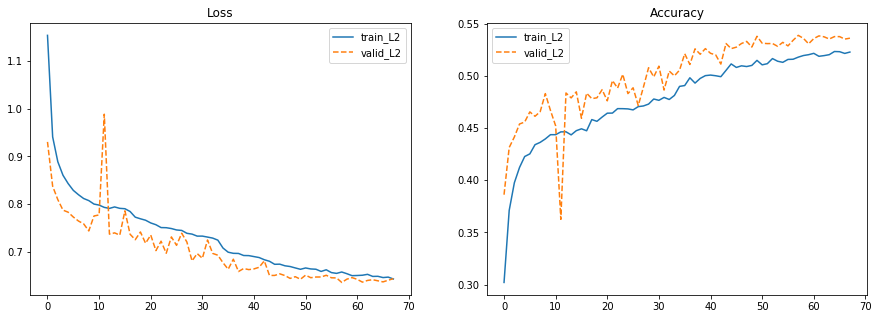

In [20]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
plot_result(record, 'L2', ax1, ax2)
plt.show()

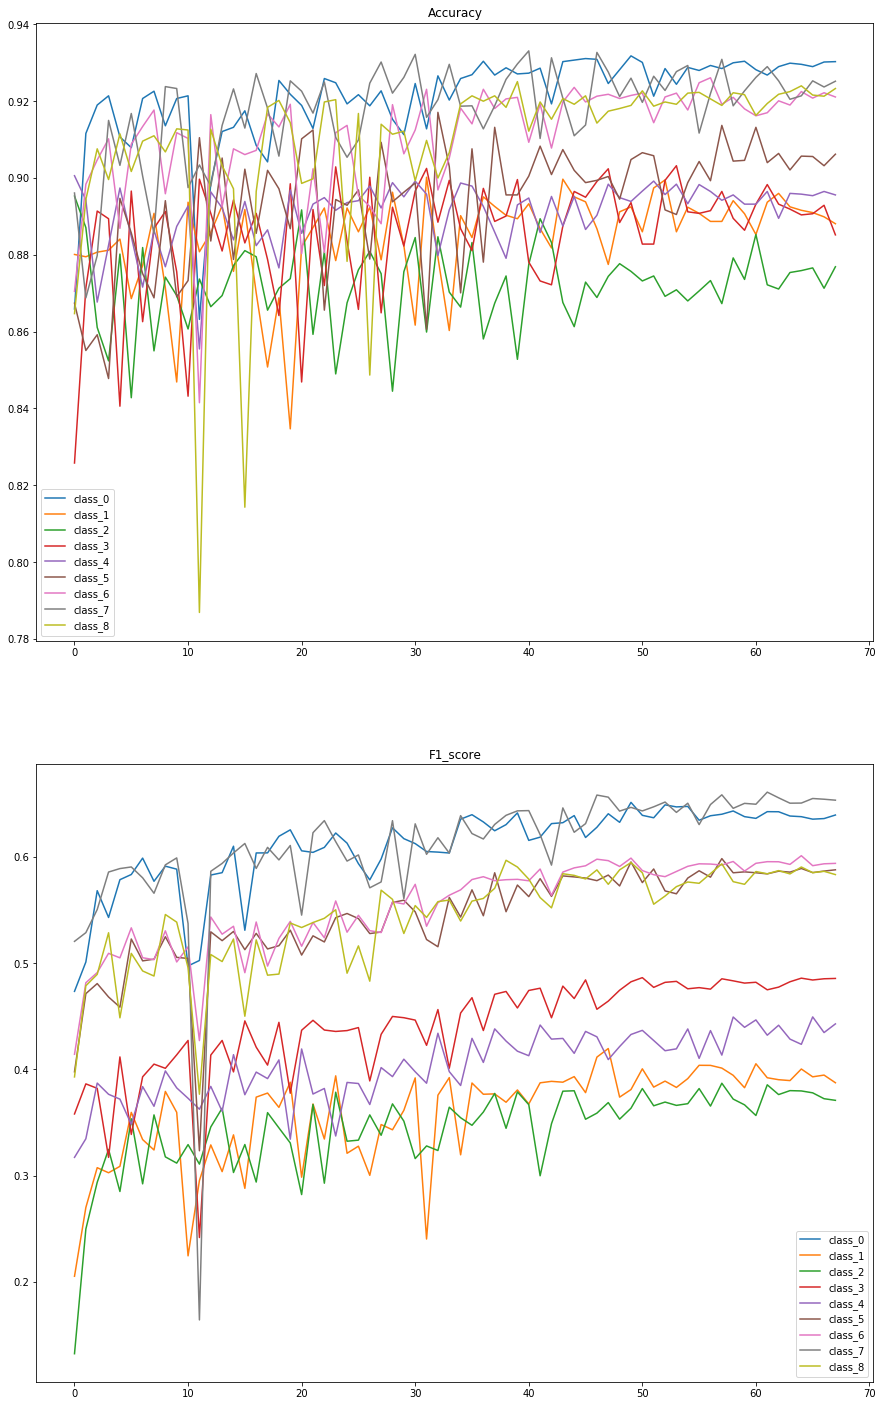

In [21]:
fig = plt.figure(figsize=[15, 25])
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for c in range(0, 9):
    tmp_cls = model.history.history['cls_'+str(c+1)]
    x = range(len(tmp_cls))
    y1, y2 = [], []
    for cc in range(len(tmp_cls)):
        y1.append(tmp_cls[cc]['ACC'])
        y2.append(tmp_cls[cc]['F1'])
    ax1.plot(x, y1, label='class_'+str(c))
    ax2.plot(x, y2, label='class_'+str(c))
ax1.set_title('Accuracy')
ax2.set_title('F1_score')
ax1.legend()
ax2.legend()
plt.show()